In [17]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

True

In [18]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from typing import List, Sequence

In [19]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Twitter expert assigned to craft outstanding tweets.
     Generate the most engaging and impactful tweet possible based on the user's request.
     If the user provides feedback, refine and enhance your previous attempts accondingly for maximum engagement.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

generate_chain = generation_prompt | llm

In [20]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [21]:
tweet = ""
request = HumanMessage(content="Fifa World Cup 26")

for chunk in generate_chain.stream({"messages": [request]}):
    print(chunk.content, end="")
    tweet += chunk.content

🌍⚽️ The excitement is building for #FIFAWorldCup2026! 🇺🇸🇨🇦🇲🇽 As the world unites for the ultimate football showdown, which teams are you rooting for? Let’s make history together! 🏆✨ #WorldCup2026 #FootballFever #SoccerUnites

# Reflect and Repeat

In [22]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are a Twitter influencer known for your enganging content and sharp insights.
Review and critique the user's tweet.
Provide constructive feedback, focusing on enhancing its depth, style and overall impact.
Offer specific suggestions to make the tweet more compelling and engaging for their audience
""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [23]:
reflect_chain = reflection_prompt | llm

In [24]:
reflect_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [25]:
reflection = ""

for chunk in reflect_chain.stream({"messages": [request, HumanMessage(content=tweet)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your tweet has a great start with the use of emojis that capture the excitement of the FIFA World Cup! However, to enhance its depth and overall impact, consider the following suggestions:

1. **Add a Personal Touch**: Share a personal story or a memorable moment from past World Cups. This helps to create a connection with your audience and encourages them to share their own experiences.

   **Example**: "I still remember the thrill of watching the 2010 final! 🌍⚽️"

2. **Engage with a Question**: Instead of just asking which teams people are rooting for, you could ask a more specific question that invites discussion. 

   **Example**: "Which underdog team do you think could surprise us this year? 🤔"

3. **Incorporate a Call to Action**: Encourage your audience to share not just their favorites, but their predictions or thoughts on the impact of hosting the World Cup across three countries.

   **Example**: "Share your predictions and thoughts on how this historic tri-nation hosting wil

In [26]:
for chunk in generate_chain.stream(
    {"messages": [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

🌍⚽️ The excitement is building for #FIFAWorldCup2026! 🇺🇸🇨🇦🇲🇽 I still remember the thrill of watching the 2010 final! Which underdog team do you think could surprise us this year? 🤔 Let’s make history together! Share your predictions on how this tri-nation hosting will shape the tournament! 🏆✨ #FootballFever #SoccerUnites 

Let's rally the fans and make this a World Cup to remember! Who's ready? 🙌⚽️

# Define the Graph

In [27]:
from langgraph.graph import END, StateGraph
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


In [28]:
class State(TypedDict):
    # Accumulate messages across nodes
    messages: Annotated[list[BaseMessage], add_messages]


def generation_node(state: State) -> dict:
    ai_msg: BaseMessage = generate_chain.invoke({"messages": state["messages"]})
    return {"messages": [ai_msg]}


def reflection_node(state: State) -> dict:
    # message to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    msgs = state["messages"]
    # first message is the original user request. we keep it the same for all nodes
    translated = [msgs[0] + [cls_map[m.type](content=m.content) for m in msgs[1:]]]
    res: BaseMessage = reflect_chain.invoke({"messages": translated})

    return {"messages": [HumanMessage(content=res.content)]}


MAX_ITERATIONS = 3


def should_continue(state: State):
    if len(state["messages"]) > MAX_ITERATIONS:
        return END
    return "reflect"


builder = StateGraph(state_schema=State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

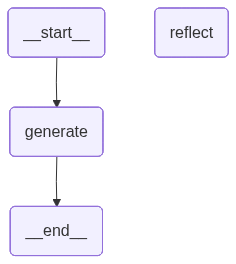

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))